## Muestreo

Para analizar la calidad del conjunto de datos, seleccionar variables, limpiar y transformar los datos y finalmente determinar un número $k$ de clusters partiremos de un muestreo del conjunto de datos inicial, con un tamaño de muestra del 3% con respecto al original. 

Para el muestreo utilizamos el método de __reservoir sapling__ visto en clase.

Como el conjunto de datos cuenta con más de 5 millones de registros, segun su [documentación](https://data.sfgov.org/Public-Safety/Fire-Department-Calls-for-Service/nuek-vuh3) fijamos el tamaño de muestra:




In [ ]:
n_muestras <- 5.4*(1*10**6)*0.3
t1 <- Sys.time()
dir()
print(n_muestras)
set.seed(0)

In [ ]:
path.file <- "Fire_Department_Calls_for_Service.csv" #--path donde se encuentra el conjunto de datos original 
n_filas_read <- 500000 # la rm nos permite cargar este numero de registros y agilizar el muestreo

connection <- file(path.file, open = "r")
#--nombre de las columnas (primera fila)
#col_names  <- read.csv(connection, nrows = 1, header = TRUE)
#--definimos nuestro buffer (muestra) y los rellenamos con las primeras n_muestras filas
buffer <- read.csv(connection, nrows = n_muestras, header = TRUE, stringsAsFactors = FALSE)

#--indice que nos permitira generar los numeros aleatorios correctamente
posicion_inicial <- n_muestras
random_unif <- function(x) sample.int(x,1)

contador <- 1
repeat{
  print(paste0("Posicion inicial: ", posicion_inicial))
  
   #--leemos una parte del archivo
  temp <- read.csv(connection, nrows = n_filas_read, header = FALSE)

  #--indices que controlan el maximo de cada numero aleatorio
  maximo <- c(1:nrow(temp)) + posicion_inicial

  #--generamos numeros aleatorios de forma vectorizada, segun esto solo permuta los indices
  j = vapply(maximo, random_unif, FUN.VALUE = integer(1))

  #--observamos cuales de los numeros aleatorios son menores que nuestra muestra
  idx <- j <= n_muestras

  #--sustituimos los que resultaron menores
  buffer[j[idx], ] <- temp[idx, ]
  
  print(paste0("iteracion: ", contador))
  contador <- contador + 1
  #--redefinimos la posicion inicial para la siguiente iteracion
  posicion_inicial <- posicion_inicial + nrow(temp)
  
  #--si el numero de filas leidas es menor que el esperado,
  #-asumimos que se acabo el archivo y salimos del ciclo
  if(nrow(temp) < n_filas_read)
    break
}
t2 <- Sys.time()
print(t2 - t1) #(Time difference of 9.29019 mins mins )
#--guardar nuestra muestra para un futuro analisis
write.csv(buffer, paste0("muestra_", path.file), row.names = FALSE )
close(connection)

In [1]:
library(readr)
data <- read_csv('muestra3_Fire_Department_Calls_for_Service.csv')

Parsed with column specification:
cols(
  .default = col_character(),
  Call.Number = col_double(),
  Incident.Number = col_double(),
  Zipcode.of.Incident = col_double(),
  Final.Priority = col_double(),
  ALS.Unit = col_logical(),
  Number.of.Alarms = col_double(),
  Unit.sequence.in.call.dispatch = col_double(),
  Supervisor.District = col_double(),
  Supervisor.Districts = col_double(),
  Fire.Prevention.Districts = col_double(),
  Current.Police.Districts = col_double(),
  Neighborhoods...Analysis.Boundaries = col_double(),
  Zip.Codes = col_double(),
  Neighborhoods..old. = col_double(),
  Police.Districts = col_double(),
  Civic.Center.Harm.Reduction.Project.Boundary = col_double(),
  HSOC.Zones = col_double(),
  Central.Market.Tenderloin.Boundary.Polygon...Updated = col_double()
)

See spec(...) for full column specifications.



In [2]:
print(dim(data))

[1] 162000     44


# Selección de variables 


Después de leer la documentación y entender la estructura de la data, decidimos que el cluster que realizaremos tendrá como objetivo encontrar grupos de llamadas parecidas entre sí y contrastaremos estos grupos con la etiqueta que poseen los datos en la columna `Call Type Group`.
Después de revisar la documentación  descartamos las columnas `Call.Type`, `RowID`, `Unit ID`, `Incident Number`, `Unit Type`, `Unit sequence in call dispatch` al igual que `Location`. Las primeras por no aportar información extra y la última porque la documentación no proporciona el tipo de proyección utilizado para referencias las coordenadas de los puntos.

In [3]:
data$RowID <- data$Unit.ID <- data$Incident.Number <- data$Location <- data$Unit.Type <- data$Unit.sequence.in.call.dispatch <- data$Call.Type <- NULL

In [4]:
names(data)

[1] "Call.Number"                                         
 [2] "Call.Date"                                           
 [3] "Watch.Date"                                          
 [4] "Received.DtTm"                                       
 [5] "Entry.DtTm"                                          
 [6] "Dispatch.DtTm"                                       
 [7] "Response.DtTm"                                       
 [8] "On.Scene.DtTm"                                       
 [9] "Transport.DtTm"                                      
[10] "Hospital.DtTm"                                       
[11] "Call.Final.Disposition"                              
[12] "Available.DtTm"                                      
[13] "Address"                                             
[14] "City"                                                
[15] "Zipcode.of.Incident"                                 
[16] "Battalion"                                           
[17] "Station.Area"                                        
[18] "Box"                                                 
[19] "Original.Priority"                                   
[20] "Priority"                                            
[21] "Final.Priority"                                      
[22] "ALS.Unit"                                            
[23] "Call.Type.Group"                                     
[24] "Number.of.Alarms"                                    
[25] "Fire.Prevention.District"                            
[26] "Supervisor.District"                                 
[27] "Neighborhooods...Analysis.Boundaries"                
[28] "Supervisor.Districts"                                
[29] "Fire.Prevention.Districts"                           
[30] "Current.Police.Districts"                            
[31] "Neighborhoods...Analysis.Boundaries"                 
[32] "Zip.Codes"                                           
[33] "Neighborhoods..old."                                 
[34] "Police.Districts"                                    
[35] "Civic.Center.Harm.Reduction.Project.Boundary"        
[36] "HSOC.Zones"                                          
[37] "Central.Market.Tenderloin.Boundary.Polygon...Updated"

En vista de que las siguientes columnas no se encuentran [documentadas en el diccionario de datos correspondiente](https://data.sfgov.org/api/views/nuek-vuh3/files/ddb7f3a9-0160-4f07-bb1e-2af744909294?download=true&filename=FIR-0002_DataDictionary_fire-calls-for-service.xlsx) procedemos a eliminarlas:
`Current Police Districts`, `Neighborhoods - Analysis Boundaries` , `Zip Codes`, `Neighborhoods (old)`, `Police Districts`, `Civic Center Harm Reduction Project Boundary`, `HSOC Zones` y  `Central Market/Tenderloin Boundary Polygon - Updated`

In [5]:
data[ , c('Current.Police.Districts', 'Neighborhoods...Analysis.Boundaries', 'Zip.Codes', 'Neighborhoods..old.', 'Police.Districts', 
          'Civic.Center.Harm.Reduction.Project.Boundary', 'HSOC.Zones', 'Central.Market.Tenderloin.Boundary.Polygon...Updated')] <- NULL

In [6]:
head(data)

Call.Number,Call.Date,Watch.Date,Received.DtTm,Entry.DtTm,Dispatch.DtTm,Response.DtTm,On.Scene.DtTm,Transport.DtTm,Hospital.DtTm,⋯,Priority,Final.Priority,ALS.Unit,Call.Type.Group,Number.of.Alarms,Fire.Prevention.District,Supervisor.District,Neighborhooods...Analysis.Boundaries,Supervisor.Districts,Fire.Prevention.Districts
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<dbl>,<lgl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
70350005,02/04/2007,02/03/2007,02/04/2007 12:17:58 AM,02/04/2007 12:20:11 AM,02/04/2007 12:20:23 AM,02/04/2007 12:21:55 AM,NA,NA,NA,⋯,3,3,TRUE,NA,1,8,4,Sunset/Parkside,3,1
21020346,04/12/2002,04/12/2002,04/12/2002 06:25:34 PM,04/12/2002 06:26:58 PM,04/12/2002 06:27:07 PM,04/12/2002 06:29:09 PM,04/12/2002 06:29:41 PM,04/12/2002 06:33:44 PM,NA,⋯,3,3,TRUE,NA,1,6,9,Mission,7,2
192952215,10/22/2019,10/22/2019,10/22/2019 01:29:33 PM,10/22/2019 01:32:23 PM,10/22/2019 01:32:57 PM,10/22/2019 01:34:13 PM,10/22/2019 01:35:53 PM,NA,NA,⋯,3,3,FALSE,Alarm,1,9,11,Outer Mission,6,9
152393922,08/27/2015,08/27/2015,08/27/2015 09:35:37 PM,08/27/2015 09:36:26 PM,08/27/2015 09:41:36 PM,08/27/2015 09:42:44 PM,NA,NA,NA,⋯,3,3,FALSE,Alarm,1,1,2,Russian Hill,1,5
122590197,09/15/2012,09/15/2012,09/15/2012 03:06:15 PM,09/15/2012 03:08:54 PM,09/15/2012 03:09:14 PM,09/15/2012 03:10:02 PM,09/15/2012 03:18:19 PM,NA,NA,⋯,1,2,TRUE,Non Life-threatening,1,9,11,Excelsior,6,9
131650329,06/14/2013,06/14/2013,06/14/2013 07:14:10 PM,06/14/2013 07:16:17 PM,06/14/2013 07:16:35 PM,06/14/2013 07:16:46 PM,06/14/2013 07:20:39 PM,06/14/2013 07:39:44 PM,06/14/2013 07:55:31 PM,⋯,3,3,TRUE,Potentially Life-Threatening,1,4,6,Tenderloin,9,13


# Limpieza de datos 


Procedemos a retener el último registro de cada llamada, el cual contiene la información acumulada de los anteriores. 

In [7]:
library(dplyr)
library(lubridate)
data$Received.DtTm <- mdy_hms(data$Received.DtTm)
data %>% group_by(Call.Number ) %>% arrange(Call.Number , Received.DtTm ) %>% mutate( flag1 = n() ,flag2 = row_number()) -> data
data %>% filter(flag1 ==flag2 ) -> data
data$flag1 <- data$flag2 <- NULL
data$Available.DtTm <- NULL
data$Call.Date <- mdy(data$Call.Date)
data$Watch.Date <- mdy(data$Watch.Date)
data$Entry.DtTm <- mdy_hms(data$Entry.DtTm)
data$Dispatch.DtTm <- mdy_hms(data$Dispatch.DtTm)
data$Response.DtTm <- mdy_hms( data$Response.DtTm) 
data$On.Scene.DtTm <- mdy_hms( data$On.Scene.DtTm) 
data$Transport.DtTm <- mdy_hms(data$Transport.DtTm) 
data$Hospital.DtTm <- mdy_hms(data$Hospital.DtTm) 



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




Como suponemos que la duración de la llamada está correlacionada con su clasificación con las variables de tipo fecha (`Call.Date`, `Watch.Date`, `Received.DtTm`, `Entry.DtTm`, `Dispatch.DtTm`, `Response.DtTm`, `On.Scene.DtTm`, `Transport.DtTm`, `Hospital.DtTm`) obtenemos la duración aproximada de la llamada. 


In [8]:
head(data)

Call.Number,Call.Date,Watch.Date,Received.DtTm,Entry.DtTm,Dispatch.DtTm,Response.DtTm,On.Scene.DtTm,Transport.DtTm,Hospital.DtTm,⋯,Priority,Final.Priority,ALS.Unit,Call.Type.Group,Number.of.Alarms,Fire.Prevention.District,Supervisor.District,Neighborhooods...Analysis.Boundaries,Supervisor.Districts,Fire.Prevention.Districts
<dbl>,<date>,<date>,<dttm>,<dttm>,<dttm>,<dttm>,<dttm>,<dttm>,<dttm>,⋯,<chr>,<dbl>,<lgl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
1030107,2000-04-12,2000-04-12,2000-04-12 21:13:47,2000-04-12 21:13:51,2000-04-12 21:14:13,2000-04-12 21:16:08,2000-04-12 21:19:16,NA,NA,⋯,3,3,FALSE,NA,1,3,6,Tenderloin,9,14
1030128,2000-04-12,2000-04-12,2000-04-12 21:45:28,2000-04-12 21:46:21,2000-04-12 21:46:45,2000-04-12 21:48:07,2000-04-12 21:49:45,NA,NA,⋯,3,3,FALSE,NA,1,5,5,Western Addition,11,15
1030172,2000-04-12,2000-04-12,2000-04-12 23:32:33,2000-04-12 23:35:26,2000-04-12 23:35:47,2000-04-12 23:38:40,2000-04-12 23:41:34,NA,NA,⋯,3,3,FALSE,NA,1,9,10,Visitacion Valley,8,9
1040032,2000-04-13,2000-04-12,2000-04-13 02:25:24,2000-04-13 02:26:01,2000-04-13 02:26:25,2000-04-13 02:29:24,2000-04-13 02:31:22,2000-04-13 02:49:37,2000-04-13 02:56:57,⋯,3,3,TRUE,NA,1,2,6,Tenderloin,9,7
1040110,2000-04-13,2000-04-13,2000-04-13 11:21:14,2000-04-13 11:21:57,2000-04-13 11:22:35,2000-04-13 11:23:38,2000-04-13 11:27:28,NA,NA,⋯,3,3,FALSE,NA,1,4,2,Marina,1,13
1040115,2000-04-13,2000-04-13,2000-04-13 11:41:52,2000-04-13 11:42:28,2000-04-13 11:42:42,2000-04-13 11:43:34,2000-04-13 11:47:59,NA,NA,⋯,3,3,TRUE,NA,1,8,7,West of Twin Peaks,4,1


In [9]:
#install.packages('reshape2')
library(reshape2)

In [10]:
data.t <- melt(data, id = c('Call.Number','Call.Final.Disposition', 'Address', 'City', 'Zipcode.of.Incident', 'Battalion', 
                            'Station.Area', 'Box', 'Original.Priority', 'Priority', 'Final.Priority', 'ALS.Unit', 'Call.Type.Group', 
                            'Number.of.Alarms',  'Fire.Prevention.District', 'Supervisor.District', 
                            'Neighborhooods...Analysis.Boundaries', 'Supervisor.Districts', 'Fire.Prevention.Districts' ) ) %>%
          filter( variable %in% c('Received.DtTm', 'Entry.DtTm', 'Dispatch.DtTm', 'Response.DtTm', 'On.Scene.DtTm', 'Transport.DtTm', 'Hospital.DtTm' )) 
head(data.t)

Warning message:
“attributes are not identical across measure variables; they will be dropped”


,Call.Number,Call.Final.Disposition,Address,City,Zipcode.of.Incident,Battalion,Station.Area,Box,Original.Priority,Priority,⋯,ALS.Unit,Call.Type.Group,Number.of.Alarms,Fire.Prevention.District,Supervisor.District,Neighborhooods...Analysis.Boundaries,Supervisor.Districts,Fire.Prevention.Districts,variable,value
,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<lgl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<fct>,<dbl>
1,1030107,Other,100 Block of JONES ST,SF,94102,B03,01,1456,3,3,⋯,FALSE,NA,1,3,6,Tenderloin,9,14,Received.DtTm,955574027
2,1030128,Other,1400 Block of STEINER ST,SF,94115,B04,05,3623,3,3,⋯,FALSE,NA,1,5,5,Western Addition,11,15,Received.DtTm,955575928
3,1030172,Other,1700 Block of SUNNYDALE AVE,SF,94134,B09,43,6241,3,3,⋯,FALSE,NA,1,9,10,Visitacion Valley,8,9,Received.DtTm,955582353
4,1040032,Other,300 Block of JONES ST,SF,94102,B03,03,1461,3,3,⋯,TRUE,NA,1,2,6,Tenderloin,9,7,Received.DtTm,955592724
5,1040110,Other,3100 Block of OCTAVIA ST,SF,94123,B04,16,3341,3,3,⋯,FALSE,NA,1,4,2,Marina,1,13,Received.DtTm,955624874
6,1040115,Other,300 Block of CASTENADA AVE,SF,94116,B08,39,8623,3,3,⋯,TRUE,NA,1,8,7,West of Twin Peaks,4,1,Received.DtTm,955626112


In [11]:
data.t %>% group_by (Call.Number, Call.Final.Disposition, Address, City, Zipcode.of.Incident, Battalion, 
                            Station.Area, Box, Original.Priority, Priority, Final.Priority, ALS.Unit, Call.Type.Group, 
                            Number.of.Alarms,  Fire.Prevention.District, Supervisor.District, 
                            Neighborhooods...Analysis.Boundaries, Supervisor.Districts, Fire.Prevention.Districts  ) %>% 
      summarise( min.t = min(value, na.rm=TRUE), max.t =max(value, na.rm=TRUE)) -> data.t
data.t <- data.t %>% mutate(Call.seconds = max.t - min.t)
data.t$min.t <- data.t$max.t <- NULL 

`summarise()` regrouping output by 'Call.Number', 'Call.Final.Disposition', 'Address', 'City', 'Zipcode.of.Incident', 'Battalion', 'Station.Area', 'Box', 'Original.Priority', 'Priority', 'Final.Priority', 'ALS.Unit', 'Call.Type.Group', 'Number.of.Alarms', 'Fire.Prevention.District', 'Supervisor.District', 'Neighborhooods...Analysis.Boundaries', 'Supervisor.Districts' (override with `.groups` argument)



In [12]:
print(dim(data.t))
tail(data.t)

[1] 156520     20


Call.Number,Call.Final.Disposition,Address,City,Zipcode.of.Incident,Battalion,Station.Area,Box,Original.Priority,Priority,Final.Priority,ALS.Unit,Call.Type.Group,Number.of.Alarms,Fire.Prevention.District,Supervisor.District,Neighborhooods...Analysis.Boundaries,Supervisor.Districts,Fire.Prevention.Districts,Call.seconds
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<lgl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
202571821,Code 2 Transport,PINE ST/TAYLOR ST,San Francisco,94108,B01,41,1413,2,3,3,FALSE,Non Life-threatening,1,1,3,Nob Hill,10,5,2274
202571847,Code 2 Transport,500 Block of 18TH AVE,San Francisco,94121,B07,14,7165,3,3,3,FALSE,Potentially Life-Threatening,1,7,1,Outer Richmond,2,11,73
202572024,Code 2 Transport,2300 Block of 18TH AV,San Francisco,94116,B08,40,7416,3,3,3,TRUE,Potentially Life-Threatening,1,8,7,West of Twin Peaks,4,1,306
202572046,Fire,200 Block of WILLIAMS AVE,San Francisco,94124,B10,42,6474,3,3,3,TRUE,Alarm,1,10,10,Bayview Hunters Point,8,10,366
202572447,Unable to Locate,2300 Block of LOMBARD ST,San Francisco,94123,B04,16,4115,3,3,3,TRUE,Potentially Life-Threatening,1,4,2,Marina,1,13,268
202572490,No Merit,1400 Block of STOCKTON ST,San Francisco,94133,B01,02,1333,A,3,3,TRUE,Potentially Life-Threatening,1,1,3,Chinatown,10,3,244


# K-means on-line

Como aplicación principal de machine learning tenemos dos objetivos, el primero es encontrar grupos de llamadas similares entre sí y que estos se contrastarlos con la etiqueta de 4 tipos que la data tiene, el segundo es asignar un tipo de llamada a los que no la tienen razón que desconocemos pues la documentación del dataset no lo declara. 


In [13]:
alpha <- 0.1
data <- as.data.frame(data.t)
kmeans.online.b.init <- function(data, k, alpha){
  # clousure para distribuir la eleccion del elemento k
  data <- data
  alpha <- alpha
  function(k){
    # Entradas 
    # data (data.frame): Dataframe donde las observaciones son los elementos a clusterizar y las columnas son las variables
    # k (int): Numero de cluster requerido
    # alpha (numeric): learning rate
    # Salida
    # kmeans.online con los elementos:
    # tabla.master (data.frame): Dos columnas, la primera con el id de la observacion y la segunda con el label del cluster
    # statas.intra (vector): Vector con la media d ela varianza intraelementos
    tabla.master <- data.frame(Obs = row.names(data), Cluster= rep(-Inf, dim(data)[1]))
    # inicializacion alatoria entre el minimo y maximo de cada variable
    stats.min <- sapply(data, min, na.rm=TRUE)
    stats.max <- sapply(data, max, na.rm=TRUE)
    set.seed(0)
    centroides <- mapply(function(x, y) {runif(k, x, y)},  stats.min, stats.max) 
    # termina inicializacion de centroides
    
    # comienza kmeans proceso online
    
    for( i in 1:dim(data)[1])
    {
      #i <- 11
      #print(i)
      # comienza asignacion de cluster mas cercano
      observacion.en.juego <- as.matrix(data[i, ])
      m.temp <- as.matrix(rbind(observacion.en.juego, centroides))
      distancias <- dist(m.temp)
      m.distancias <- as.matrix(distancias)
      k.i <- which.min(m.distancias[1, 2:(k+1)])
      tabla.master$Cluster[i] <- k.i
      # termina asignacion de cluster mas cercano 
      # update de cluster
      centroides[k.i, ] <- centroides[k.i, ] + alpha*observacion.en.juego
    }
    stats <- rep(-Inf, k)
    for ( i in 1:k)
    {
      index <- which( tabla.master$Cluster == i)
      data.subset <- data[ index, ]
      stats.i <- dist(data.subset)
      stats[i] <- sum(stats.i) # asumimos independencia entre las variables
    }
    kmeans.online <- list( tabla.master =tabla.master, statas.intra = stats)
    return(kmeans.online)
  }
}

In [14]:
Y <- data.frame(y=data$Call.Type.Group)
row.names(Y) <- row.names(data) <- data$Call.Number
data$Call.Type.Group <- data$Call.Number <- NULL
# hacemos un cambio de encoding de las variables ordinales para no hacer una matriz con muchas variables ---IMPORTANTE

In [15]:
index <- which(is.na(Y$y))
Y$y <- as.character(Y$y) 
Y$y[index] <- 'No asignado'
sapply(data, class) 

Call.Final.Disposition                              Address 
                         "character"                          "character" 
                                City                  Zipcode.of.Incident 
                         "character"                            "numeric" 
                           Battalion                         Station.Area 
                         "character"                          "character" 
                                 Box                    Original.Priority 
                         "character"                          "character" 
                            Priority                       Final.Priority 
                         "character"                            "numeric" 
                            ALS.Unit                     Number.of.Alarms 
                           "logical"                            "numeric" 
            Fire.Prevention.District                  Supervisor.District 
                         "character"                            "numeric" 
Neighborhooods...Analysis.Boundaries                 Supervisor.Districts 
                         "character"                            "numeric" 
           Fire.Prevention.Districts                         Call.seconds 
                           "numeric"                            "numeric"

In [16]:
index <- which(sapply(data, class) == 'character')
normalizar <- function(x, na.rm = FALSE) (x - mean(x, na.rm = na.rm)) / sd(x, na.rm)
index

Call.Final.Disposition                              Address 
                                   1                                    2 
                                City                            Battalion 
                                   3                                    5 
                        Station.Area                                  Box 
                                   6                                    7 
                   Original.Priority                             Priority 
                                   8                                    9 
            Fire.Prevention.District Neighborhooods...Analysis.Boundaries 
                                  13                                   15

In [17]:
# mas preprocesamiento de datos
for (i in index)
    {
    index.na <- which( is.na(data[, i] ))
    data[index.na, i] <- 'NULL'
    temp <- factor( data[, i])
    data[, i] <- normalizar(as.numeric( temp))
}

In [22]:

# mas preprocesamiento de datos
for (i in colnames(data)[-index])
    {
    index.na <- which( is.na(data[, i] ))
    data[index.na, i] <- 0
    data[, i] <- normalizar( data[, i] )
}

In [23]:
head(data)

,Call.Final.Disposition,Address,City,Zipcode.of.Incident,Battalion,Station.Area,Box,Original.Priority,Priority,Final.Priority,ALS.Unit,Number.of.Alarms,Fire.Prevention.District,Supervisor.District,Neighborhooods...Analysis.Boundaries,Supervisor.Districts,Fire.Prevention.Districts,Call.seconds
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1030107,0.8492751,-1.19899740,0.676538,0.04705520,-0.6118794,-1.1889860,-1.0224294,0.00901584,0.07929734,0.5320778,-1.2936691,-0.0439306,-0.33218476,0.008999371,1.0640611,0.574616,1.2893561,-0.03368536
1030128,0.8492751,-0.81876540,0.676538,0.04985101,-0.2724127,-0.9104910,-0.1992745,0.00901584,0.07929734,0.5320778,-1.2936691,-0.0439306,0.37842041,-0.358105547,1.4410459,1.247552,1.5164995,-0.03725323
1030172,0.8492751,-0.63736627,0.676538,0.05393718,1.4249208,1.6655875,0.8387749,0.00901584,0.07929734,0.5320778,-1.2936691,-0.0439306,1.79963075,1.477419042,1.2902520,0.238148,0.1536396,-0.02317997
1040032,0.8492751,0.09021638,0.676538,0.04705520,-0.6118794,-1.0497385,-1.0206083,0.00901584,0.07929734,0.5320778,0.7729903,-0.0439306,-0.68748735,0.008999371,1.0640611,0.574616,-0.3006471,0.04381665
1040110,0.8492751,0.17650234,0.676538,0.05157150,-0.2724127,-0.1446299,-0.3777461,0.00901584,0.07929734,0.5320778,-1.2936691,-0.0439306,0.02311782,-1.459420300,-0.4438782,-2.117128,1.0622128,-0.03145544
1040115,0.8492751,0.05689367,0.676538,0.05006607,1.0854541,1.3870925,2.1026456,0.00901584,0.07929734,0.5320778,0.7729903,-0.0439306,1.44432816,0.376104289,1.3656490,-1.107724,-1.6635070,-0.03180232


In [24]:
sum(table(Y$y)) # distribucion del etiquetamiento del tipo de llamada
print(table( Y$y))

[1] 156520


                       Alarm                         Fire 
                       17372                         2742 
                 No asignado         Non Life-threatening 
                       81989                        18348 
Potentially Life-Threatening 
                       36069 


In [25]:
kmeans.online.b <- kmeans.online.b.init(data = data, alpha = alpha)

In [26]:
set.seed(0)
cluster <- 1:4
t1 <- Sys.time()
for( i in cluster)
{
  print(i)
  res <- kmeans.online.b(k=2*i+1)
  cluster[i] <- sum(res$statas.intra)
  print(cluster)
}
t2 <- Sys.time()

[1] 1
[1] 33332541892           2           3           4
[1] 2
[1] 33332541892 16185130722           3           4
[1] 3
[1] 33332541892 16185130722 12454278666           4
[1] 4
[1] 33332541892 16185130722 12454278666  9056367816


In [27]:
t2-t1

Time difference of 15.90825 mins

In [28]:
2*1:4 + 1

[1] 3 5 7 9

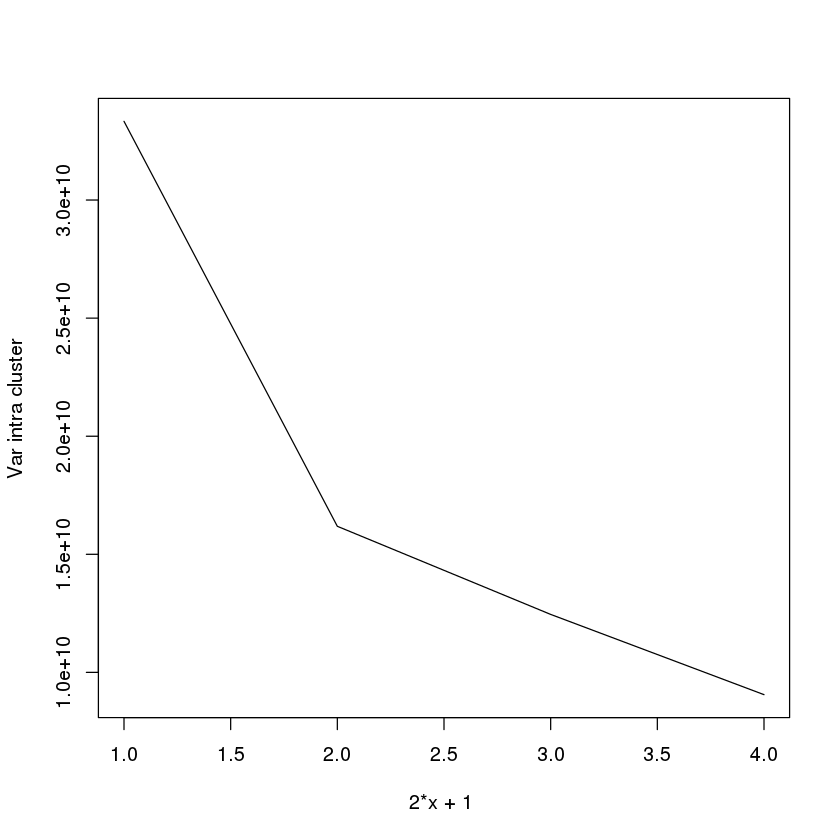

In [29]:
plot((cluster),type = 'l', xlab = '2*x + 1 ', ylab = 'Var intra cluster')

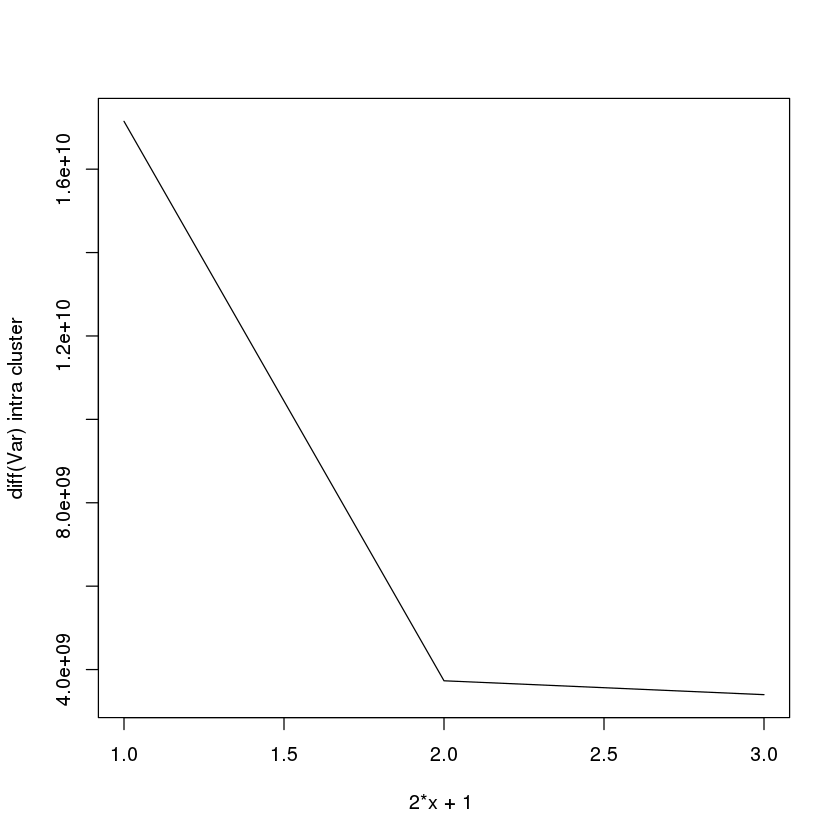

In [30]:
plot(abs(diff(cluster)),type = 'l',  xlab = '2*x + 1 ', ylab = 'diff(Var) intra cluster')

Por lo que consideramos que una elección de $k=7$ es adecuada y ejecutamos el algoritmo de kmeans online implementado sobre el conjunto completo de datos. 

In [33]:
k = 5

In [39]:
library(reshape2)
library(dplyr)
library(lubridate)
data <- read.csv('Fire_Department_Calls_for_Service.csv', stringsAsFactors = FALSE)
print(head(data))

data$RowID <- data$Unit.ID <- data$Incident.Number <- data$Location <- data$Unit.Type <- data$Unit.sequence.in.call.dispatch <- data$Call.Type <- NULL
data[ , c('Current.Police.Districts', 'Neighborhoods...Analysis.Boundaries', 'Zip.Codes', 'Neighborhoods..old.', 'Police.Districts', 
          'Civic.Center.Harm.Reduction.Project.Boundary', 'HSOC.Zones', 'Central.Market.Tenderloin.Boundary.Polygon...Updated')] <- NULL
data$Received.DtTm <- mdy_hms(data$Received.DtTm)
data %>% group_by(Call.Number ) %>% arrange(Call.Number , Received.DtTm ) %>% mutate( flag1 = n() ,flag2 = row_number()) -> data
data %>% filter(flag1 ==flag2 ) -> data
data$flag1 <- data$flag2 <- NULL
data$Available.DtTm <- NULL
data$Call.Date <- mdy(data$Call.Date)
data$Watch.Date <- mdy(data$Watch.Date)
data$Entry.DtTm <- mdy_hms(data$Entry.DtTm)
data$Dispatch.DtTm <- mdy_hms(data$Dispatch.DtTm)
data$Response.DtTm <- mdy_hms( data$Response.DtTm) 
data$On.Scene.DtTm <- mdy_hms( data$On.Scene.DtTm) 
data$Transport.DtTm <- mdy_hms(data$Transport.DtTm) 
data$Hospital.DtTm <- mdy_hms(data$Hospital.DtTm) 
data.t <- melt(data, id = c('Call.Number','Call.Final.Disposition', 'Address', 'City', 'Zipcode.of.Incident', 'Battalion', 
                            'Station.Area', 'Box', 'Original.Priority', 'Priority', 'Final.Priority', 'ALS.Unit', 'Call.Type.Group', 
                            'Number.of.Alarms',  'Fire.Prevention.District', 'Supervisor.District', 
                            'Neighborhooods...Analysis.Boundaries', 'Supervisor.Districts', 'Fire.Prevention.Districts' ) ) %>%
          filter( variable %in% c('Received.DtTm', 'Entry.DtTm', 'Dispatch.DtTm', 'Response.DtTm', 'On.Scene.DtTm', 'Transport.DtTm', 'Hospital.DtTm' )) 
data.t %>% group_by (Call.Number, Call.Final.Disposition, Address, City, Zipcode.of.Incident, Battalion, 
                            Station.Area, Box, Original.Priority, Priority, Final.Priority, ALS.Unit, Call.Type.Group, 
                            Number.of.Alarms,  Fire.Prevention.District, Supervisor.District, 
                            Neighborhooods...Analysis.Boundaries, Supervisor.Districts, Fire.Prevention.Districts  ) %>% 
      summarise( min.t = min(value, na.rm=TRUE), max.t =max(value, na.rm=TRUE)) -> data.t
data.t <- data.t %>% mutate(Call.seconds = max.t - min.t)
data.t$min.t <- data.t$max.t <- NULL 
data.t <- as.data.frame(data.t)

print(dim(data.t))
Y <- data.frame(y=data.t$Call.Type.Group)
row.names(Y) <- row.names(data.t) <- data.t$Call.Number
data.t$Call.Type.Group <- data.t$Call.Number <- NULL
# hacemos un cambio de encoding de las variables ordinales para no hacer una matriz con muchas variables ---IMPORTANTE
index <- which(is.na(Y$y))
Y$y <- as.character(Y$y) 
Y$y[index] <- 'No asignado'
index <- which(sapply(data.t, class) == 'character')

normalizar <- function(x, na.rm = FALSE) (x - mean(x, na.rm = na.rm)) / sd(x, na.rm)
# mas preprocesamiento de datos
for (i in index)
    {
    index.na <- which( is.na(data.t[, i] ))
    data.t[index.na, i] <- 'NULL'
    temp <- factor( data.t[, i])
    data.t[, i] <- normalizar(as.numeric( temp))
}
for (i in colnames(data.t)[-index])
    {
    index.na <- which( is.na(data.t[, i] ))
    data.t[index.na, i] <- 0
    data.t[, i] <- normalizar( data.t[, i] )
}
head(data.t)

  Call.Number Unit.ID Incident.Number        Call.Type  Call.Date Watch.Date
1   201560006      86        20064818 Medical Incident 06/04/2020 06/03/2020
2   201560006     E48        20064818 Medical Incident 06/04/2020 06/03/2020
3   201560006    RA48        20064818 Medical Incident 06/04/2020 06/03/2020
4   201560012      94        20064819 Medical Incident 06/04/2020 06/03/2020
5   201560019     E01        20064820     Outside Fire 06/04/2020 06/03/2020
6   201560029      53        20064821 Medical Incident 06/04/2020 06/03/2020
           Received.DtTm             Entry.DtTm          Dispatch.DtTm
1 06/04/2020 12:00:17 AM 06/04/2020 12:02:00 AM 06/04/2020 12:02:09 AM
2 06/04/2020 12:00:17 AM 06/04/2020 12:02:00 AM 06/04/2020 12:02:09 AM
3 06/04/2020 12:00:17 AM 06/04/2020 12:02:00 AM 06/04/2020 12:02:09 AM
4 06/04/2020 12:03:15 AM 06/04/2020 12:05:31 AM 06/04/2020 12:05:48 AM
5 06/04/2020 12:09:59 AM 06/04/2020 12:11:01 AM 06/04/2020 12:11:53 AM
6 06/04/2020 12:17:34 AM 06/04/2020

Warning message:
“attributes are not identical across measure variables; they will be dropped”
`summarise()` regrouping output by 'Call.Number', 'Call.Final.Disposition', 'Address', 'City', 'Zipcode.of.Incident', 'Battalion', 'Station.Area', 'Box', 'Original.Priority', 'Priority', 'Final.Priority', 'ALS.Unit', 'Call.Type.Group', 'Number.of.Alarms', 'Fire.Prevention.District', 'Supervisor.District', 'Neighborhooods...Analysis.Boundaries', 'Supervisor.Districts' (override with `.groups` argument)



[1] 2442878      20


,Call.Final.Disposition,Address,City,Zipcode.of.Incident,Battalion,Station.Area,Box,Original.Priority,Priority,Final.Priority,ALS.Unit,Number.of.Alarms,Fire.Prevention.District,Supervisor.District,Neighborhooods...Analysis.Boundaries,Supervisor.Districts,Fire.Prevention.Districts,Call.seconds
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1030101,0.9081488,-0.3832730,0.5983279,0.06791769,1.0959416,0.01515439,-1.382416,0.2173244,0.3039489,0.7023039,0.7168879,-0.0148378,1.4651812,-0.2072683,0.9777683,-1.4691221,-1.6765356,-0.1521352
1030104,0.9081488,-0.6620982,0.5983279,0.06886677,1.0959416,0.36411570,1.668121,0.2173244,0.3039489,0.7023039,0.7168879,-0.0148378,1.4651812,-0.2072683,0.9777683,-1.4691221,-1.6765356,0.3161206
1030106,0.9081488,-1.4591089,0.5983279,0.06570316,-0.9415835,1.20162285,-0.530643,0.2173244,0.3039489,0.7023039,-1.3949177,-0.0148378,-0.6850764,0.4911210,1.0532408,0.5645766,-0.3096065,0.3678055
1030107,0.9081488,-1.1769414,0.5983279,0.06570316,-0.6019960,-1.17131407,-1.022259,0.2173244,0.3039489,0.7023039,-1.3949177,-0.0148378,-0.3267001,0.4911210,1.0532408,0.5645766,1.2851443,-0.1170897
1030108,0.9081488,0.6663387,0.5983279,0.06665224,-0.6019960,-1.17131407,-1.119501,0.2173244,0.3039489,0.7023039,0.7168879,-0.0148378,-1.4018289,-0.5564629,-1.2864096,0.9035264,-0.7652495,0.1486971
1030112,0.9081488,0.7646796,0.5983279,0.06681042,-1.2811711,-1.03172954,-1.016856,0.2173244,0.3039489,0.7023039,-1.3949177,-0.0148378,-1.4018289,-0.5564629,-0.1543207,0.9035264,-0.7652495,-0.1126722


In [40]:
alpha <- 0.1
t1 <- Sys.time()
tabla.master <- data.frame(Obs = row.names(data.t), Cluster= rep(-Inf, dim(data.t)[1]))
    # inicializacion alatoria entre el minimo y maximo de cada variable
head(tabla.master)

,Obs,Cluster
,<fct>,<dbl>
1,1030101,-Inf
2,1030104,-Inf
3,1030106,-Inf
4,1030107,-Inf
5,1030108,-Inf
6,1030112,-Inf


In [41]:
stats.min <- sapply(data.t, min, na.rm=TRUE)
stats.max <- sapply(data.t, max, na.rm=TRUE)
set.seed(0)
centroides <- mapply(function(x, y) {runif(k, x, y)},  stats.min, stats.max) 
    # termina inicializacion de centroides

# comienza kmeans proceso online
    for( i in 1:dim(data.t)[1])
    {
      if(i %% 10000 ==0 )
      print(i)
      # comienza asignacion de cluster mas cercano
      observacion.en.juego <- as.matrix(data.t[i, ])
      m.temp <- as.matrix(rbind(observacion.en.juego, centroides))
      distancias <- dist(m.temp)
      m.distancias <- as.matrix(distancias)
      k.i <- which.min(m.distancias[1, 2:(k+1)])
      tabla.master$Cluster[i] <- k.i
      # termina asignacion de cluster mas cercano 
      # update de cluster
      centroides[k.i, ] <- centroides[k.i, ] + alpha*observacion.en.juego
    }
t2 <- Sys.time()

[1] 10000
[1] 20000
[1] 30000
[1] 40000
[1] 50000
[1] 60000
[1] 70000
[1] 80000
[1] 90000
[1] 100000
[1] 110000
[1] 120000
[1] 130000
[1] 140000
[1] 150000
[1] 160000
[1] 170000
[1] 180000
[1] 190000
[1] 200000
[1] 210000
[1] 220000
[1] 230000
[1] 240000
[1] 250000
[1] 260000
[1] 270000
[1] 280000
[1] 290000
[1] 300000
[1] 310000
[1] 320000
[1] 330000
[1] 340000
[1] 350000
[1] 360000
[1] 370000
[1] 380000
[1] 390000
[1] 400000
[1] 410000
[1] 420000
[1] 430000
[1] 440000
[1] 450000
[1] 460000
[1] 470000
[1] 480000
[1] 490000
[1] 500000
[1] 510000
[1] 520000
[1] 530000
[1] 540000
[1] 550000
[1] 560000
[1] 570000
[1] 580000
[1] 590000
[1] 600000
[1] 610000
[1] 620000
[1] 630000
[1] 640000
[1] 650000
[1] 660000
[1] 670000
[1] 680000
[1] 690000
[1] 700000
[1] 710000
[1] 720000
[1] 730000
[1] 740000
[1] 750000
[1] 760000
[1] 770000
[1] 780000
[1] 790000
[1] 800000
[1] 810000
[1] 820000
[1] 830000
[1] 840000
[1] 850000
[1] 860000
[1] 870000
[1] 880000
[1] 890000
[1] 900000
[1] 910000
[1] 9200

In [42]:
t2 - t1

Time difference of 4.585974 hours

In [45]:
index <- which(Y$y == '')
Y$y <- as.character(Y$y) 
Y$y[index] <- 'No asignado'
tabla.master$etiqueta.original <- Y$y
table(tabla.master$etiqueta.original, tabla.master$Cluster)

                              
                                    1      2      3      4      5
  Alarm                         72476    818   4736  11956 133269
  Fire                          10493    155   1132   1766  16706
  No asignado                  266279 248390 242547 186773 307888
  Non Life-threatening         133358  36146  22578   7229 202301
  Potentially Life-Threatening 183312  11975  17803  20042 302750

In [46]:
write.csv(tabla.master, file='resultados_cluster_5.csv')